# Edge Detection Algos
    STEP 1: Finding new Lanes - grayscale conversion
    Edge Detection = identifying sharp changes in intensity in adjecent pixels
    Gradients: measure of change in brightness over adjacent pixels

    0->255 = Strong Gradient  0 -> 15 = Small Gradient

    edge: rapid changes in brightness

-1

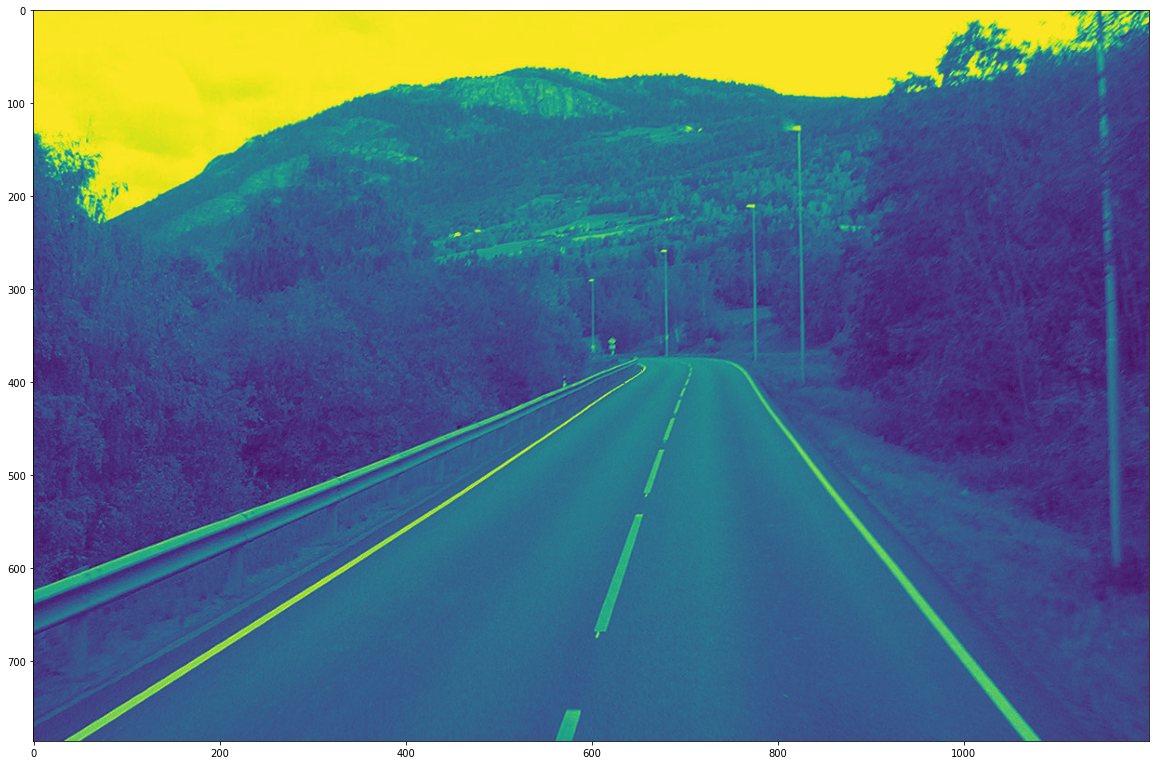

In [3]:
# first we perform grayscaling for the sake of dimensionality reduction from 3 channel to 1 channel

import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("Road_in_Norway.jpg")
lane_image = np.copy(img)
gray = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)
plt.figure(figsize = (20,20))
plt.imshow(gray)
cv2.imshow('our gray image', gray)
cv2.waitKey(0)

    -> STEP 2: REDUCE NOISE by Gaussian Blur

In [4]:
blur = cv2.GaussianBlur(gray, (5,5), 0)
cv2.imshow("our blur image", blur)
cv2.waitKey(0)

-1

    -> STEP 3: Applying the Canny method to identify the edges in image to get gradient image
    gradient image = (difference of two consequtive pixels in a column, lets say (column 10 row 5) - (column 10, row 6))/(difference of column 10 row 5 and column 11 row 5)
    gradient_image = ((5,10)-(6,10)) / ((5,10)-(5,11))

    image = [[0,0,255,255],
             [0,0,255,255],
             [0,0,255,255],
             [0,0,255,255]]  0 = Black, 255 = White
    gradient calculation = |0-0|/|0-255| = -infinity
    cv2.Canny(image, low_threshold, high_threshold)

In [5]:
canny = cv2.Canny(blur, 50, 150)
cv2.imshow('our gradient image', canny)
cv2.waitKey(0)

-1

    -> STEP 4: FINDING THE LANE LINES by Region of Interest


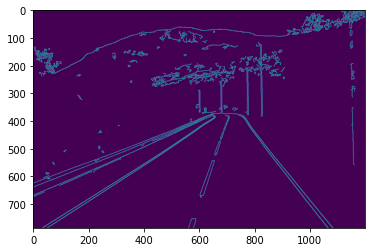

-1

In [9]:
import matplotlib.pyplot as plt

def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    canny = cv2.Canny(blur, 50, 150)
    return canny

canny = canny(lane_image)

# lets identify which x and y pixels gives us our lane's triangle shape ((500, image.height), (1100,height), (750,300))
plt.imshow(canny)
plt.show()

def region_of_interest(image):
    img_height = image.shape[0]
    # triange = np.array([(),(),()])
    polygons = np.array([
        [(530, img_height),(1120, img_height),(724, 322)]
        ])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    return mask

cv2.imshow('our ROI image', region_of_interest(canny))
cv2.waitKey(0)

    -> STEP 5: BITWISE AND OPERATION between canny image and ROI image to get only white lane overlapping white ROI triangle
    bitwise and(&) operation => 1 & 1 = 1, 1 & 0 = 0, 0 & 0 = 0, 0 & 1 = 0 
    binary(2 based) represantation of 0 = 0000 (4-bit)
    binary representation of 255 = 11111111 (8-bit)
    in canny image, lane lines are white(255 in 10 based)(11111111 in 2 based)
    in ROI image, polygon is white and overlaying the lanes
    so when we perform bitwise operation we get only 1&1 = 1 values in output image, only lanes are white others black

In [10]:
# add bit-wise operation to region_of_interest function

def region_of_interest(image):
    img_height = image.shape[0]
    # triange = np.array([(),(),()])
    polygons = np.array([
        [(530, img_height),(1120, img_height),(724, 322)]
        ])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255) # cv2.fillPoly(img1, img2, polygon_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

#canny = canny(lane_image)
cropped_image = region_of_interest(canny)
cv2.imshow('our Cropped image', cropped_image)
cv2.waitKey(0)

-1

    -> STEP 6: HOUGH TRANSFORM to detect the straight lines in our ROI

In [12]:
import cv2
import numpy as np

img = cv2.imread('Road_in_Norway.jpg')
np_img = np.copy(img)

def canny(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    canny = cv2.Canny(gray, 50,150)
    return canny

def ROI(img):
    mask = np.zeros_like(img)
    img_height = img.shape[0]
    triangle_points = np.array([[(530, img_height),(1120, img_height),(724, 322)]])
    cv2.fillPoly(mask, triangle_points, 255)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

def display_lines(img, lines):
    line_img = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_img, (x1,y1), (x2,y2), (255, 0, 0), 10)
    return line_img

canny_img = canny(np_img)
roi_img = ROI(canny_img)
lines = cv2.HoughLinesP(roi_img, 2, np.pi/180, 100, np.array([]), minLineLength = 40, maxLineGap=5)
line_img = display_lines(np_img, lines)
combo_img = cv2.addWeighted(np_img, 0.8, line_img, 1, 1)
cv2.imshow('result', combo_img)
cv2.waitKey(0)

-1

    --> STEP 7: Find the parameters of lines made by coordinates of hough space, then take average of them with respect to slope sign, then create new two lines by using average slope and intercept values

-1

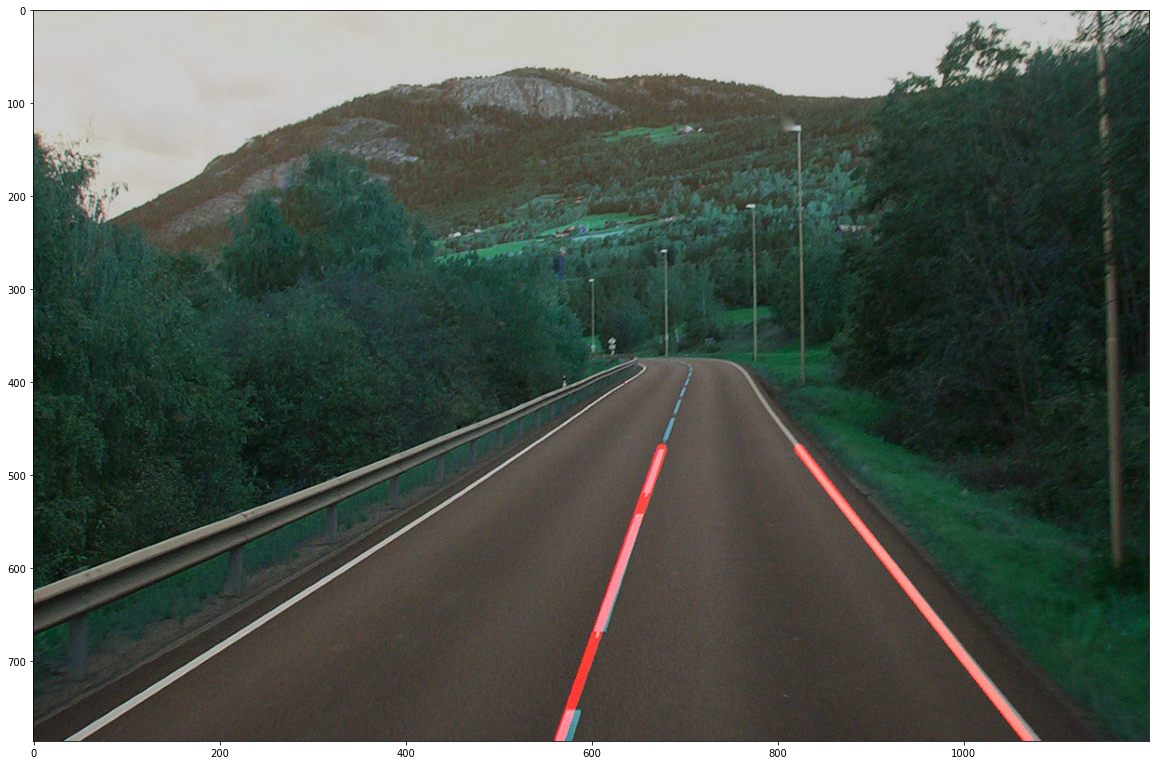

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('Road_in_Norway.jpg')
np_img = np.copy(img)

def canny(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    canny = cv2.Canny(blur, 50, 150)
    return canny

def region_of_interest(img):
    mask = np.zeros_like(img)
    img_height = img.shape[0]
    triangle_points = np.array([[[(530, img_height),(1120, img_height),(724, 322)]]])
    cv2.fillPoly(mask, triangle_points, 255)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

def display_lines(img, lines_coordinates):
    line_img = np.zeros_like(img)
    if lines_coordinates is not None:
        for x1, y1, x2, y2 in lines_coordinates:
            cv2.line(line_img, (x1,y1), (x2,y2), (255,0,0), 10)
    return line_img

def make_coodinates(img, line_parameters):
    slope, intercept = line_parameters
    y1 = img.shape[0]
    x1 = int( (y1-intercept)/slope )
    y2 = int(y1*(3/5))
    x2 = int( (y2-intercept)/slope )
    return np.array([x1,y1,x2,y2])

def average_slope_intercept(img, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        # least-squares polynomial fit by numpy
        parameters = np.polyfit(x = [x1,x2], y = [y1,y2], deg =1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope<0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis = 0)
    right_fit_average = np.average(right_fit, axis = 0)
    left_line = make_coodinates(img, left_fit_average)
    right_line = make_coodinates(img, right_fit_average)
    
    return np.array([left_line, right_line])

    


canny_img = canny(np_img)
masked_img = region_of_interest(canny_img)
lines = cv2.HoughLinesP(masked_img, 2, np.pi/180, 100, np.array([]), minLineLength = 40, maxLineGap=5)
averaged_lines = average_slope_intercept(np_img, lines)
line_img = display_lines(np_img, averaged_lines)
combo_img = cv2.addWeighted(np_img, 0.8, line_img, 1, 1)
plt.figure(figsize=(20,20))
plt.imshow(combo_img)
cv2.imshow("result", combo_img)
cv2.waitKey(0)